In [23]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [101]:
#Load data
df = pd.read_csv('household_power_consumption.txt' , sep = ';' , na_values='?' )
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


### Data Profile

In [102]:
df.shape

(2075259, 9)

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    float64
 3   Global_reactive_power  float64
 4   Voltage                float64
 5   Global_intensity       float64
 6   Sub_metering_1         float64
 7   Sub_metering_2         float64
 8   Sub_metering_3         float64
dtypes: float64(7), object(2)
memory usage: 142.5+ MB


In [104]:
df.isna().sum()

Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [107]:
# select 15000 sample of data 
data = df.dropna().sample(15000)
data.drop(['Date', 'Time'] , axis = 1 , inplace = True)

## Univariate analysis

In [109]:
data.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [110]:
# calculating total consumption of energy
data['Total'] = data['Sub_metering_1'] + data['Sub_metering_2'] + data['Sub_metering_3']

In [111]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Global_active_power,15000.0,1.093449,1.062526,0.078,0.310,0.602,1.528,8.404
Global_reactive_power,15000.0,0.123629,0.112838,0.000,0.048,0.100,0.194,1.078
Voltage,15000.0,240.805288,3.237766,225.250,238.960,240.990,242.840,253.430
Global_intensity,15000.0,4.637173,4.468189,0.200,1.400,2.600,6.400,36.000
Sub_metering_1,15000.0,1.118600,6.106594,0.000,0.000,0.000,0.000,76.000
Sub_metering_2,15000.0,1.265733,5.806287,0.000,0.000,0.000,1.000,76.000
Sub_metering_3,15000.0,6.483800,8.464395,0.000,0.000,1.000,17.000,30.000
Total,15000.0,8.868133,12.801852,0.000,0.000,1.000,18.000,127.000


**Some fields have outliers such as Sub_metering_1,2,3 and global_intensity**

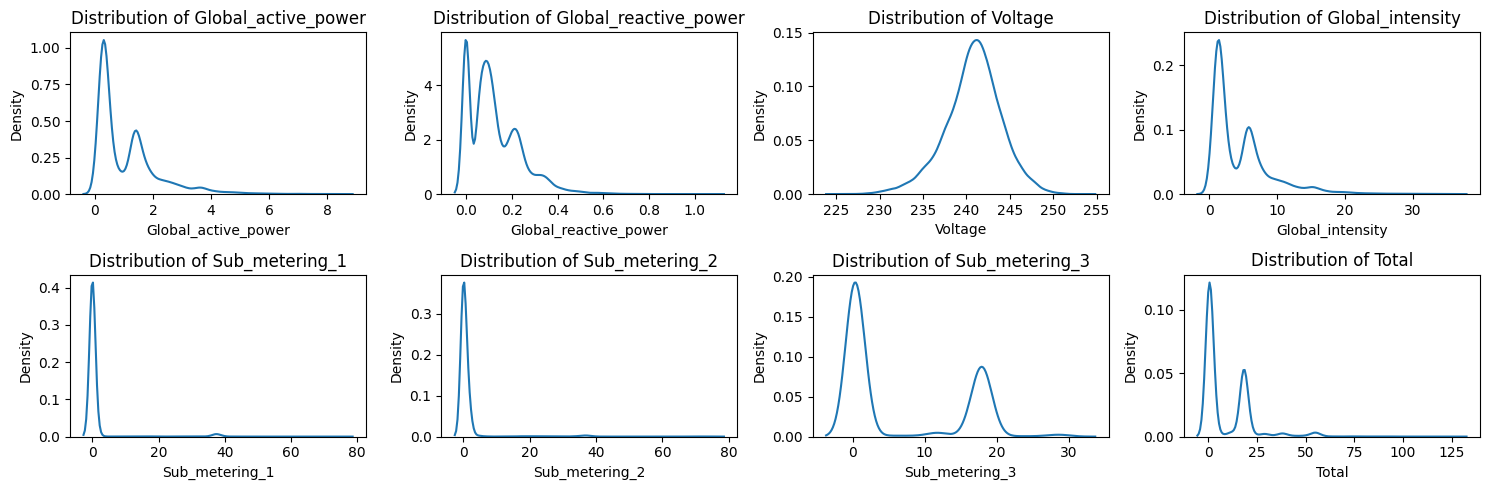

In [117]:
# Plot Distribution of columns
i = 1
plt.figure(figsize=(15, 5))
for col in data.columns:
    plt.subplot(2,4,i)
    sns.kdeplot(data[col])
    plt.title('Distribution of '+ col);
    plt.tight_layout()
    i+=1

Report:
- Voltage has normal distribution
- ither field are right skew 

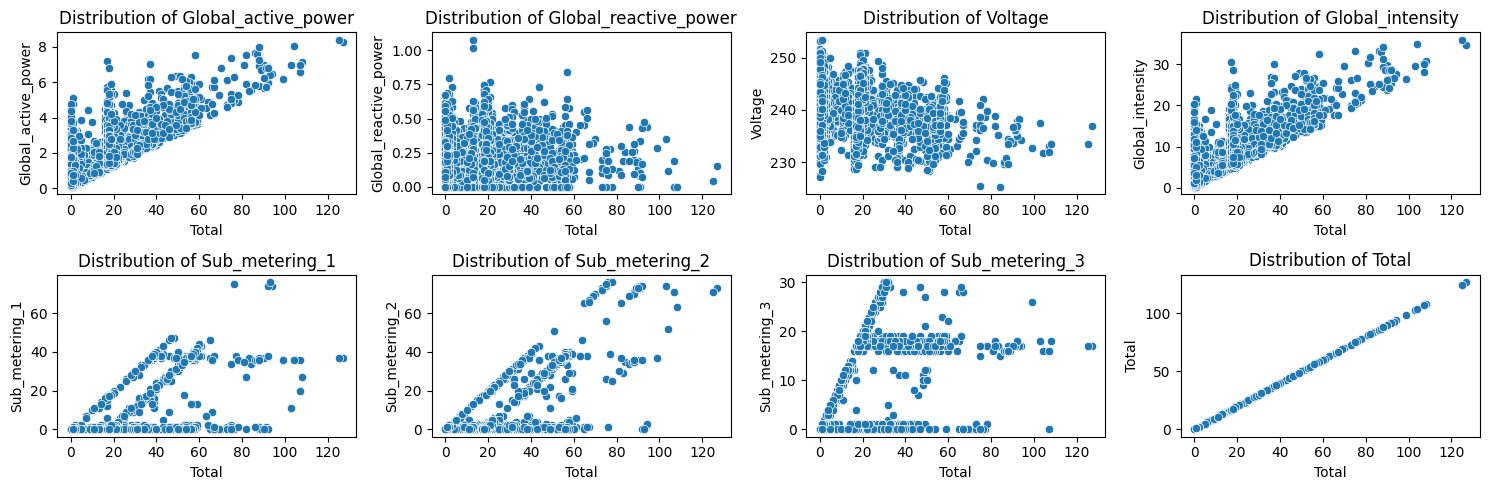

In [119]:
# Plot corelation between columns and target
i = 1
plt.figure(figsize=(15, 5))
for col in data.columns:
    plt.subplot(2,4,i)
    sns.scatterplot(df, x = data['Total'] , y = data[col])
    plt.title('Distribution of '+ col);
    plt.tight_layout()
    i+=1

Report:
    - Some linear relation is observed between Global_active_power and Global_intensity with target field

<AxesSubplot: >

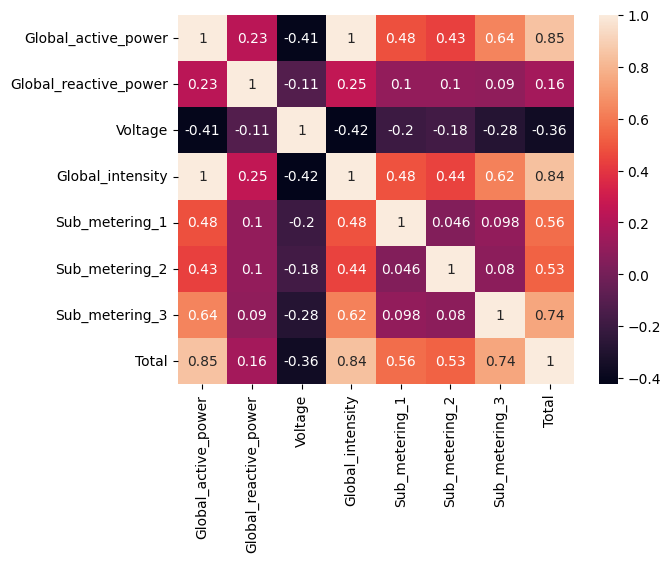

In [266]:
sns.heatmap(data.corr(), annot=True)

Report:
- There is high corelation between Global_active_pover with Global_intensity
- The correlation between each Sub_metering and total is minor, 
- There is hiigh correlation between Gloobal_intensity and Total columns


### Modeling

In [267]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression , Ridge , Lasso , ElasticNet
from sklearn.metrics import mean_absolute_error , mean_squared_error , r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

In [269]:
# Select X and y , As Global_intensity is completely  correated to Global_active_power we will drop it
X = data.drop(['Total', 'Global_intensity'], axis = 1)
y = data['Total']

In [270]:
# Split data into train and test
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size= 0.2, random_state=42)
X_train.shape , X_test.shape , y_train.shape , y_test.shape

((12000, 6), (3000, 6), (12000,), (3000,))

In [271]:
# Scale data to be in same range for reducig computational process improve loss calculation
X_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [272]:
# Model Linear Regression and calculate the score
reg_model = LinearRegression()
reg_model.fit(X_train_scaled , y_train)
reg_model.score(X_train_scaled, y_train)

1.0

In [275]:
## print the coefficients and the intercept
print(reg_model.coef_)
print(reg_model.intercept_)

[ 5.78996312e-15 -9.61148690e-16  4.23172523e-15  6.24944840e+00
  5.81393957e+00  8.44455051e+00]
8.902


In [291]:
# Predict on test data ad evaluation of the model
reg_preds = reg_model.predict(X_test_scaled)
print('MSE: ', mean_squared_error(reg_preds , y_test))
print('RMSE', np.sqrt(mean_squared_error(reg_preds , y_test)))
print('MAE: ', mean_absolute_error(reg_preds , y_test))
print('R2 score: ', r2_score(reg_preds , y_test))
print('Adjusted R2 score:', 1- ((1- r2_score(reg_preds , y_test) * (len(y_test) -1)) / (len(y_test)- X.shape[1] -1 )))

MSE:  7.009476164068315e-29
RMSE 8.372261441252485e-15
MAE:  6.730912123960782e-15
R2 score:  1.0
Adjusted R2 score: 2.001670564650852


**Report:**
- data has a lot of outlier then MAE and Adjusted R2 score is important to be sure about result
- also we should check Ridge because in case of outlier this model will work better 

**Controling assumptions of Regression model**

1- linear relation between actual values and predicted values - there is linear relation between actual and predicted values

2- normal distribution of residuals - In following plot it does not normal distribution and left skeness which shows model is not good 

3- uniform distribution between predicton values and residuals - there is negative correlation which shows model is not good

Text(0, 0.5, 'Test Predicted Data')

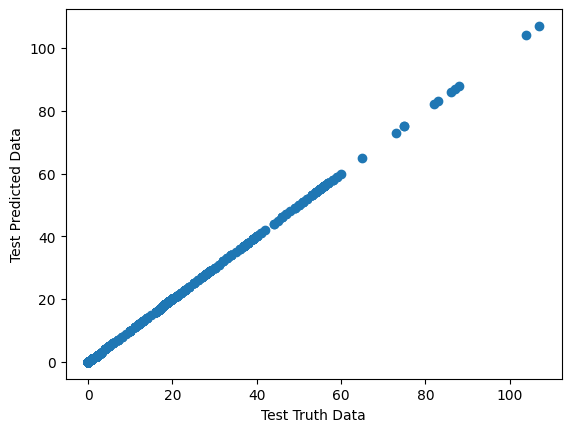

In [278]:
# Is there any linear relation between y_preds and y
plt.scatter(y_test, reg_preds)
plt.xlabel("Test Truth Data")
plt.ylabel("Test Predicted Data")

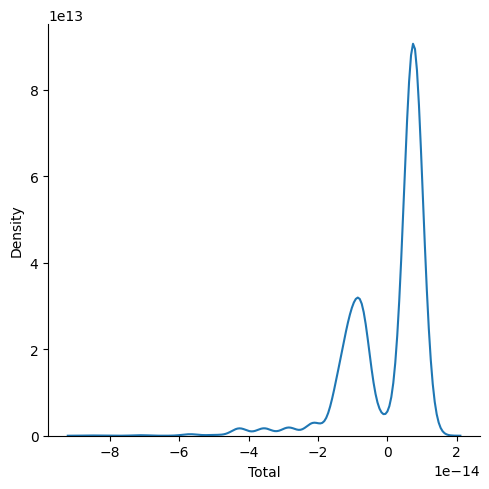

In [220]:
## calculate residuals and plot its distribution
reg_residuals=y_test-reg_preds
sns.displot(reg_residuals,kind="kde")

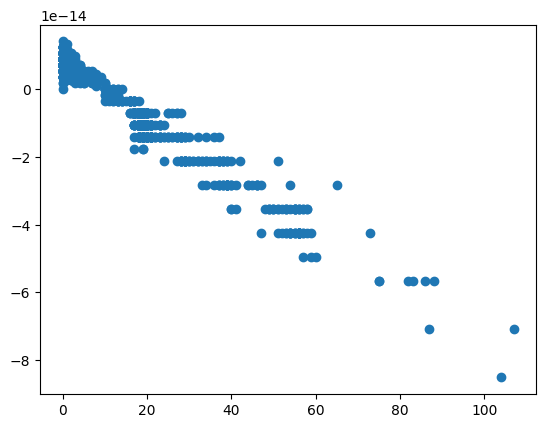

In [221]:
## SCatter plot of predictions and residual to check uniform distribution
plt.scatter(reg_preds,reg_residuals)

In [279]:
# Ridge model
ridge_model = Ridge()
ridge_model.fit(X_train_scaled , y_train)
ridge_model.score(X_train_scaled, y_train)

0.9999999812784065

In [292]:
ridge_preds = ridge_model.predict(X_test_scaled)
print('MSE: ', mean_squared_error(ridge_preds , y_test))
print('RMSE', np.sqrt(mean_squared_error(ridge_preds , y_test)))
print('MAE: ', mean_absolute_error(ridge_preds , y_test))
print('R2 score: ', r2_score(ridge_preds , y_test))
print('Adjusted R2 score:', 1- ((1- r2_score(ridge_preds , y_test) * (len(y_test) -1)) / (len(y_test)- X.shape[1] -1 )))

MSE:  3.0335103221919404e-06
RMSE 0.001741697540387521
MAE:  0.0010979504659205583
R2 score:  0.999999980520415
Adjusted R2 score: 2.0016705451322165


Text(0, 0.5, 'Test Predicted Data')

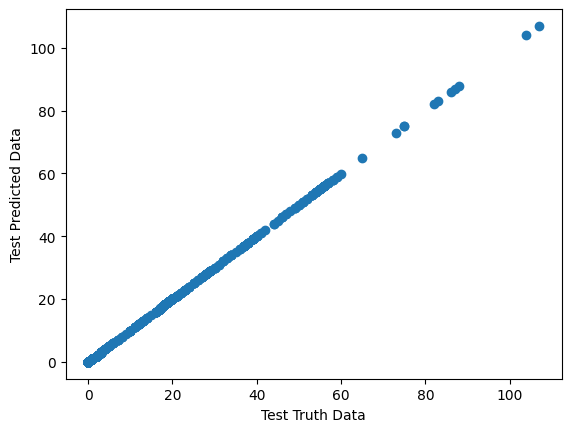

In [281]:
# Is there any linear relation between y_preds and y
plt.scatter(y_test, ridge_preds)
plt.xlabel("Test Truth Data")
plt.ylabel("Test Predicted Data")

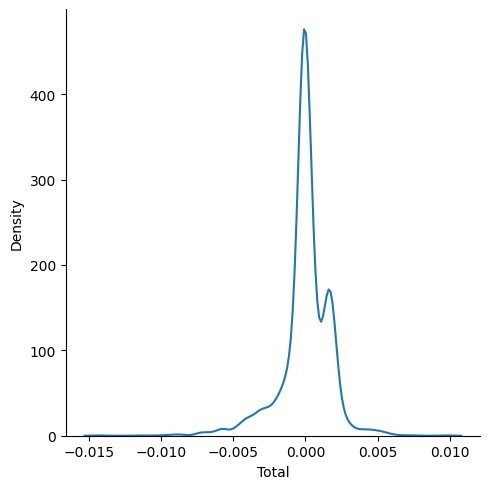

In [282]:
## residuals
ridge_residuals=y_test-ridge_preds
sns.displot(ridge_residuals,kind="kde")

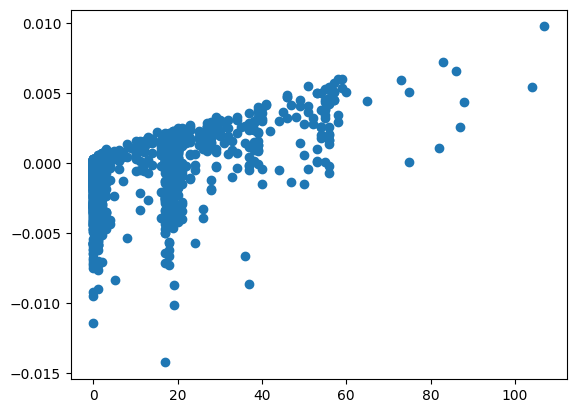

In [283]:
## SCatter plot of predictions and residual to check uniform distribution
plt.scatter(ridge_preds,ridge_residuals)

**Controling assumptions of Ridge model**

1- linear relation between actual values and predicted values - there is linear relation between actual and predicted values

2- normal distribution of residuals - In following plot it is near to normal distribution with some left skew

3- uniform distribution between predicton values and residuals - it seems less correlation and this model is beter than Linear Regression

In [284]:
# Lasso Model
lasso_model = Lasso()
lasso_model.fit(X_train_scaled, y_train)
lasso_model.score(X_train_scaled, y_train)

0.9817016391323267

In [293]:
lasso_preds = lasso_model.predict(X_test_scaled)
print('MSE: ', mean_squared_error(lasso_preds , y_test))
print('RMSE', np.sqrt(mean_squared_error(lasso_preds , y_test)))
print('MAE: ', mean_absolute_error(lasso_preds , y_test))
print('R2 score: ', r2_score(lasso_preds , y_test))
print('Adjusted R2 score:', 1- ((1- r2_score(lasso_preds , y_test) * (len(y_test) -1)) / (len(y_test)- X.shape[1] -1 )))

MSE:  2.7916620032661
RMSE 1.6708267424440213
MAE:  1.1587764009479704
R2 score:  0.9768865710081337
Adjusted R2 score: 1.978510800686065


Text(0, 0.5, 'Test Predicted Data')

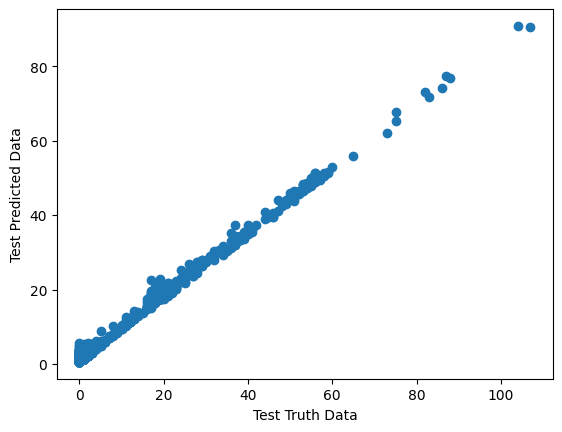

In [286]:
# Is there any linear relation between y_preds and y
plt.scatter(y_test, lasso_preds)
plt.xlabel("Test Truth Data")
plt.ylabel("Test Predicted Data")

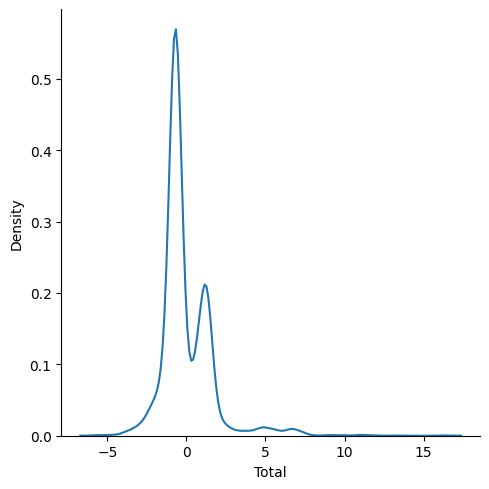

In [287]:
## residuals
lasso_residuals=y_test-lasso_preds
sns.displot(lasso_residuals,kind="kde")

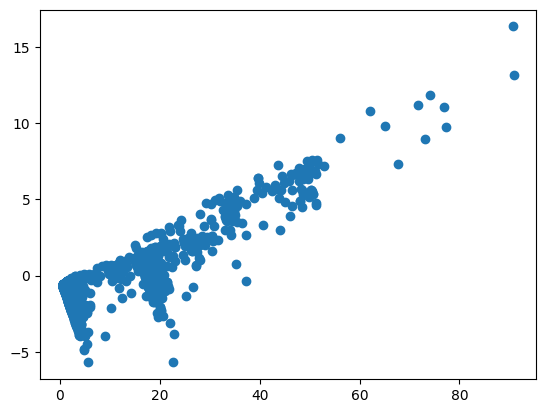

In [288]:
## SCatter plot of predictions and residual to check uniform distribution
plt.scatter(lasso_preds,lasso_residuals)

**Controling assumptions of Lasso model**

1- linear relation between actual values and predicted values - there is linear relation but it is not as powerful as previous models

2- normal distribution of residuals - In following plot it doesnot normal distribution and also there is some left skewness

3- uniform distribution between predicton values and residuals - there is some positive correlation which shows model is not good

In [294]:
# elasticNet model and evaluation
elastic_model = ElasticNet()
elastic_model.fit(X_train_scaled , y_train)
print('Score of model on train data: ',elastic_model.score(X_train_scaled , y_train))

elastic_preds = elastic_model.predict(X_test_scaled)
print('MSE: ', mean_squared_error(elastic_preds , y_test))
print('RMSE', np.sqrt(mean_squared_error(elastic_preds , y_test)))
print('MAE: ', mean_absolute_error(elastic_preds , y_test))
print('R2 score: ', r2_score(elastic_preds , y_test))
print('Adjusted R2 score:', 1- ((1- r2_score(elastic_preds , y_test) * (len(y_test) -1)) / (len(y_test)- X.shape[1] -1 )))

Score of model on train data:  0.9025865206827152
MSE:  15.118184228996817
RMSE 3.8882109290773843
MAE:  2.8923494466739164
R2 score:  0.8222953091715863
Adjusted R2 score: 1.823609633212692


Text(0, 0.5, 'Test Predicted Data')

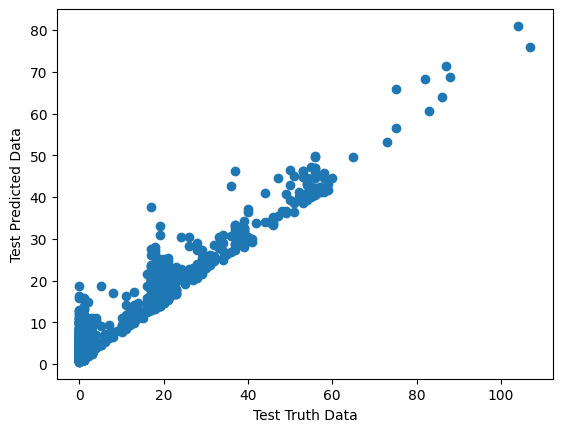

In [234]:
# Is there any linear relation between y_preds and y
plt.scatter(y_test, elastic_preds)
plt.xlabel("Test Truth Data")
plt.ylabel("Test Predicted Data")

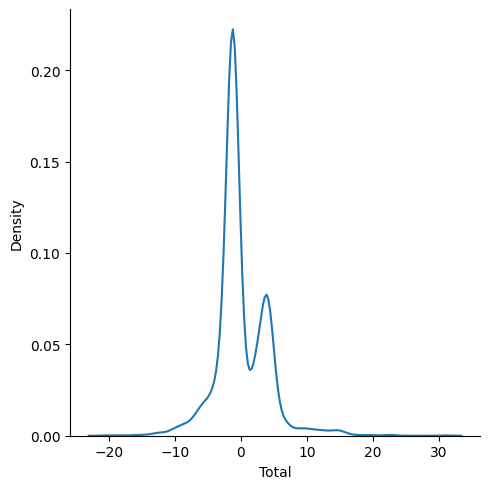

In [235]:
## residuals
elastic_residuals=y_test-elastic_preds
sns.displot(elastic_residuals,kind="kde")

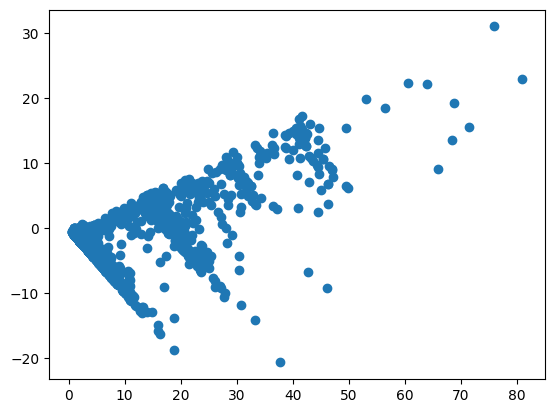

In [236]:
## SCatter plot of predictions and residual to check uniform distribution
plt.scatter(elastic_preds,elastic_residuals)

Controling assumptions of ElasticNet model

1- linear relation between actual values and predicted values - there is linear relation but it is not as powerful as Ridge models

2- normal distribution of residuals - In following plot it is near normal distribution with some right skewness

3- uniform distribution between predicton values and residuals - there is some small positive correlation which shows model is not good

### Hyperparameter tuning

In [237]:
param = {
    'alpha' : [.01, .1 , .5, 1, 2, 3, 5],  
    'l1_ratio' : [0.05 , 0.5, 0.1, 1],
    'max_iter' : [500, 1000, 10000],
    'tol' : [.0001, .00001, .001]
}

elastic_grid_model = GridSearchCV(elastic_model, param, refit = True, verbose = 3, n_jobs=-1) 
   
# fitting the model for grid search 
elastic_grid_model.fit(X_train_scaled, y_train) 
 
# best parameter
print('Beat parameters are: ' , elastic_grid_model.best_params_) 

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Beat parameters are:  {'alpha': 0.01, 'l1_ratio': 1, 'max_iter': 500, 'tol': 1e-05}


In [238]:
# Predict with best model
grid_elastic_preds = elastic_grid_model.predict(X_test_scaled)
print('MSE: ', mean_squared_error(grid_elastic_preds , y_test))
print('RMSE', np.sqrt(mean_squared_error(grid_elastic_preds , y_test)))
print('MAE: ', mean_absolute_error(grid_elastic_preds , y_test))
print('R2 score: ', r2_score(grid_elastic_preds , y_test))
print('Adjusted R2 score:', 1- ((1- r2_score(grid_elastic_preds , y_test) * (len(y_test) -1)) / (len(y_test)- 7 -1 )))

MSE:  0.00028005516531638767
RMSE 0.01673484882860875
MAE:  0.011601245382055614
R2 score:  0.9999981975186544
Adjusted R2 score: 2.0020035408952017


Text(0, 0.5, 'Test Predicted Data')

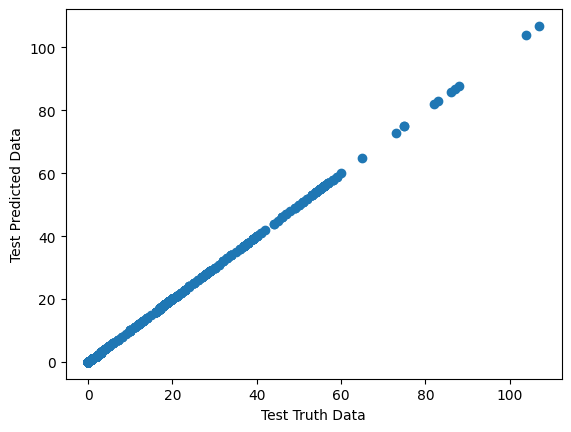

In [239]:
# Is there any linear relation between y_preds and y
plt.scatter(y_test, grid_elastic_preds)
plt.xlabel("Test Truth Data")
plt.ylabel("Test Predicted Data")

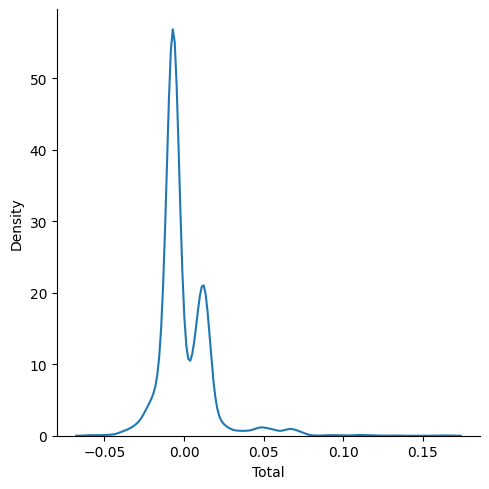

In [240]:
## residuals
grid_residuals=y_test-grid_elastic_preds
sns.displot(grid_residuals,kind="kde")

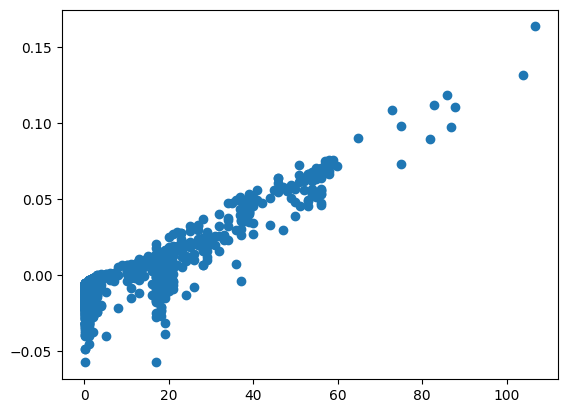

In [241]:
## SCatter plot of predictions and residual to check uniform distribution
plt.scatter(grid_elastic_preds,grid_residuals)

**Controling assumptions of Lasso model**

1- linear relation between actual values and predicted values - there is linear relation 

2- normal distribution of residuals - In following plot it doesnot normal distribution and also there is some right skewness

3- uniform distribution between predicton values and residuals - there is some positive correlation which shows model is not good

### Among all the best model is Ridge

**Removing Sub_metering columns which our target calculated by them**

In [297]:
X = data.drop(['Total', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Global_intensity'], axis = 1)
y = data['Total']

X_train , X_test , y_train , y_test = train_test_split(X , y , test_size= 0.2, random_state=42)
print(X_train.shape , X_test.shape , y_train.shape , y_test.shape)

X_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

(12000, 3) (3000, 3) (12000,) (3000,)


Score on train data:  0.7196734733745549
MSE:  45.27167632927952
RMSE 6.7284230194956915
MAE:  4.2055513575844365
R2 score:  0.6151315499940242
Adjusted R2 score: 1.6162364700641974


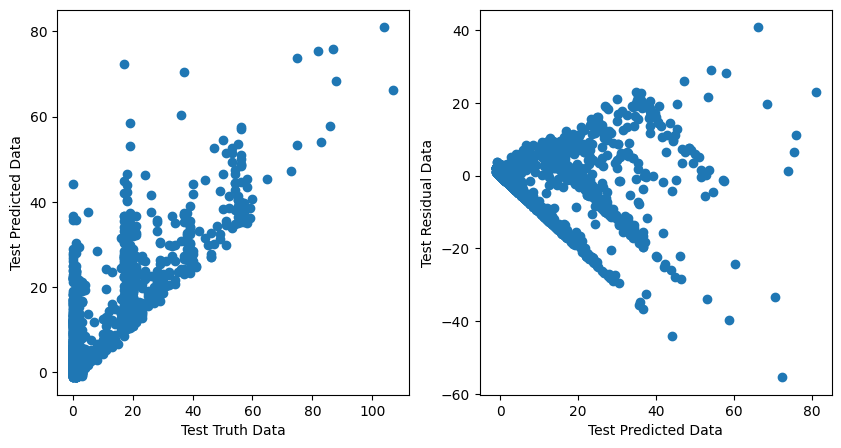

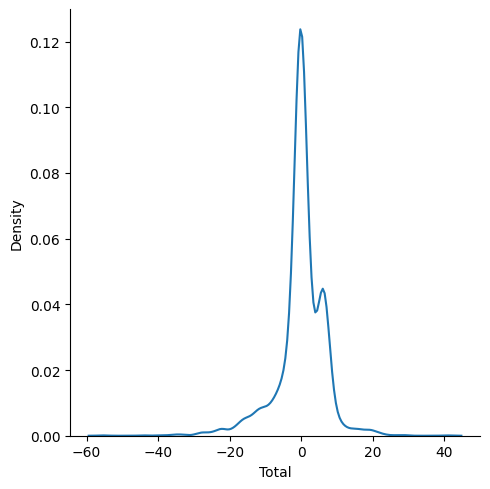

In [298]:
# Run the best previous model to compare the results
ridge_model = Ridge()
ridge_model.fit(X_train_scaled , y_train)
ridge_model.score(X_train_scaled , y_train)
print('Score on train data: ', ridge_model.score(X_train_scaled , y_train))

ridge_preds = ridge_model.predict(X_test_scaled)
print('MSE: ', mean_squared_error(ridge_preds , y_test))
print('RMSE', np.sqrt(mean_squared_error(ridge_preds , y_test)))
print('MAE: ', mean_absolute_error(ridge_preds , y_test))
print('R2 score: ', r2_score(ridge_preds , y_test))
print('Adjusted R2 score:', 1- ((1- r2_score(ridge_preds , y_test) * (len(y_test) -1)) / (len(y_test)- 7 -1 )))

# Is there any linear relation between y_preds and y
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(y_test, ridge_preds)
plt.xlabel("Test Truth Data")
plt.ylabel("Test Predicted Data")

## residuals
ridge_residuals=y_test-ridge_preds

## SCatter plot of predictions and residual to check uniform distribution
plt.subplot(1,2,2)
plt.scatter(ridge_preds,ridge_residuals)
plt.xlabel("Test Predicted Data")
plt.ylabel("Test Residual Data")

sns.displot(ridge_residuals,kind="kde")

**Controling assumptions of Lasso model**

1- linear relation between actual values and predicted values - there is poor linear relation 

2- normal distribution of residuals - In following plot it doesnot completely normal distribution and also there is some left skewness

3- uniform distribution between predicton values and residuals - there is not correlation

4- The performance of the model decrease

### Try with SVR model

In [299]:
X = data.drop(['Total', 'Global_intensity'], axis = 1)
y = data['Total']

# Split data to train and test
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size= 0.2, random_state=42)
print(X_train.shape , X_test.shape , y_train.shape , y_test.shape)

# Scale data
X_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

(12000, 6) (3000, 6) (12000,) (3000,)


In [300]:
svr_model = SVR()
svr_model.fit(X_train_scaled, y_train)
svr_model.score(X_train_scaled, y_train)

0.9343260240519494

In [301]:
svr_preds = svr_model.predict(X_test_scaled)
print('MSE: ', mean_squared_error(svr_preds , y_test))
print('RMSE', np.sqrt(mean_squared_error(svr_preds , y_test)))
print('MAE: ', mean_absolute_error(svr_preds , y_test))
print('R2 score: ', r2_score(svr_preds , y_test))
print('Adjusted R2 score:', 1- ((1- r2_score(svr_preds , y_test) * (len(y_test) -1)) / (len(y_test)- 7 -1 )))

MSE:  10.84726229493181
RMSE 3.293518224472397
MAE:  0.42038104036591006
R2 score:  0.9169314731655717
Adjusted R2 score: 1.9187424759436997


### Hyperparameter tuning of SVR

In [303]:
param = {
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],  
    'C' : [.1, .01, 1, 2]
}

svr_grid_model = GridSearchCV(svr_model, param, refit = True, verbose = 3, n_jobs=-1) 
   
# fitting the model for grid search 
svr_grid_model.fit(X_train_scaled, y_train) 
 
# best parameter
print('Beat parameters are: ' , svr_grid_model.best_params_) 

svr_grid_preds = svr_grid_model.predict(X_test_scaled)
print('MSE: ', mean_squared_error(svr_grid_preds , y_test))
print('RMSE', np.sqrt(mean_squared_error(svr_grid_preds , y_test)))
print('MAE: ', mean_absolute_error(svr_grid_preds , y_test))
print('R2 score: ', r2_score(svr_grid_preds , y_test))
print('Adjusted R2 score:', 1- ((1- r2_score(svr_grid_preds , y_test) * (len(y_test) -1)) / (len(y_test)- 7 -1 )))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Beat parameters are:  {'C': 0.1, 'kernel': 'linear'}
MSE:  0.001766492447666761
RMSE 0.04202966152215315
MAE:  0.03901315536790695
R2 score:  0.9999886008071965
Adjusted R2 score: 2.001993921731545


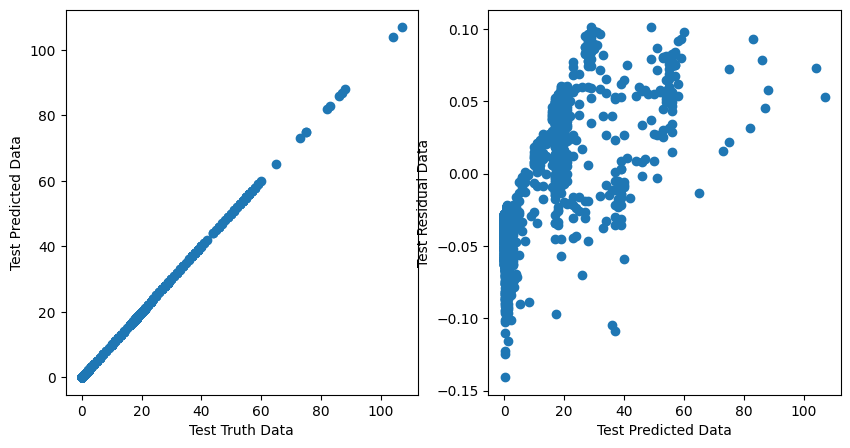

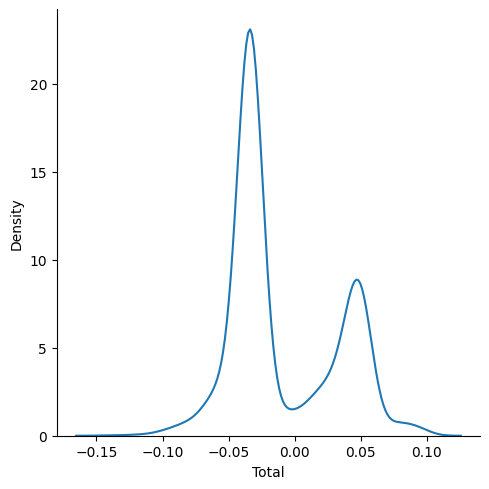

In [304]:
# Is there any linear relation between y_preds and y
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(y_test,svr_grid_preds)
plt.xlabel("Test Truth Data")
plt.ylabel("Test Predicted Data")

## residuals
svr_grid_residuals=y_test-svr_grid_preds

## SCatter plot of predictions and residual to check uniform distribution
plt.subplot(1,2,2)
plt.scatter(svr_grid_preds,svr_grid_residuals)
plt.xlabel("Test Predicted Data")
plt.ylabel("Test Residual Data")

sns.displot(svr_grid_residuals,kind="kde")